# Table of Contents

* [0. Data loading](#section_0)
* [1. EDA](#section_1)
* [2. Setup validation and baselines](#section_2)
* [3. Feature engineering](#section_3)
* [4. Modeling](#section_4)
    * [4.1 Logistic regression](#section_4_1)
    * [4.2 Random Forest](#section_4_2)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);

# 0. Data loading <a class="anchor" id="section_0"></a>

In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [3]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]

frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)
        
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


In [4]:
raw_data.shape

(6462, 91)

# 1. EDA <a class="anchor" id="section_1"></a>

We can see that there is class imbalance: only 165 samples of 'stairs' class

In [5]:
raw_data.label.value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

## Distibution of readings across each axis

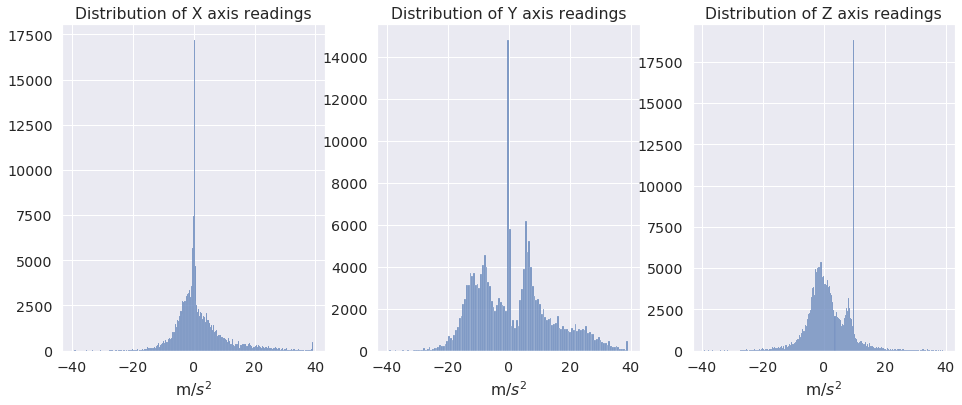

In [378]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes = axes.flatten()

for label, cols, ax in zip(['X', 'Y', 'Z'], [x_acc_cols, y_acc_cols, z_acc_cols], axes):
    sns.histplot(raw_data[cols].values.flatten(), ax=ax)
    ax.set_title(f'Distribution of {label} axis readings');
    ax.set_xlabel('m/$s^2$');
    ax.set_ylabel('')

We can see that all readings are centered around zero. X axis is approximately normally distributed, while Y and Z looks like bimodal distributions.

## t-SNE visualization

In [404]:
from sklearn.manifold import TSNE

In [405]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(raw_data[x_acc_cols+y_acc_cols+z_acc_cols])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6462 samples in 0.049s...
[t-SNE] Computed neighbors for 6462 samples in 4.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6462
[t-SNE] Computed conditional probabilities for sample 2000 / 6462
[t-SNE] Computed conditional probabilities for sample 3000 / 6462
[t-SNE] Computed conditional probabilities for sample 4000 / 6462
[t-SNE] Computed conditional probabilities for sample 5000 / 6462
[t-SNE] Computed conditional probabilities for sample 6000 / 6462
[t-SNE] Computed conditional probabilities for sample 6462 / 6462
[t-SNE] Mean sigma: 0.386747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.203568
[t-SNE] KL divergence after 300 iterations: 2.506890


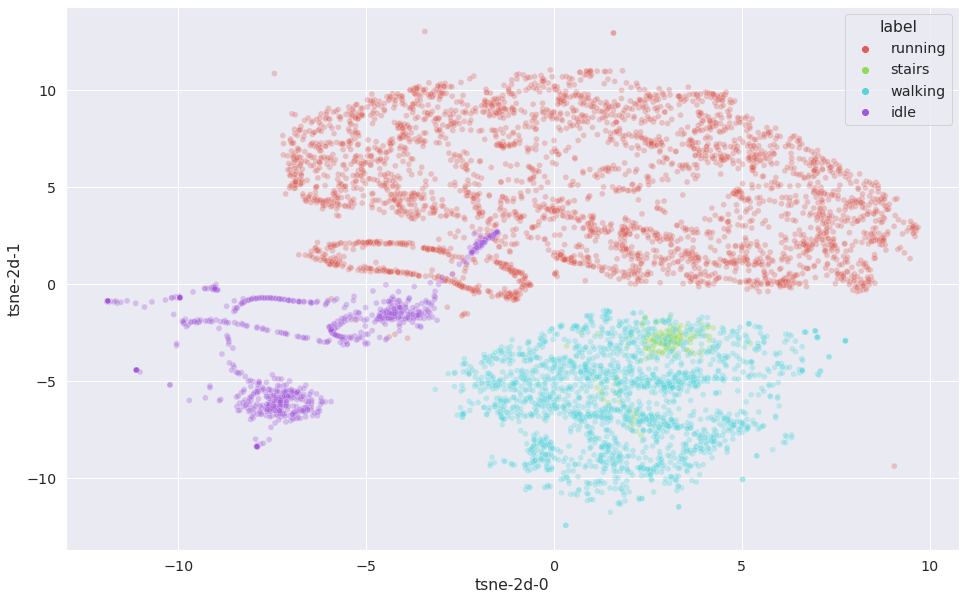

In [408]:
df_subset = pd.DataFrame({
    'tsne-2d-0': tsne_results[:,0],
    'tsne-2d-1': tsne_results[:,1],
    'label': raw_data['label'],
})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-0", y="tsne-2d-1",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=df_subset,
    legend="full",
    alpha=0.3
);

t-SNE transformation, applied on raw accelerometer data in a frame of length 30, is visualized on 2d plane. We can see 3 clusters here:
- running
- idle
- stairs + walking

## Sample activities

Visualize one sample for each activity

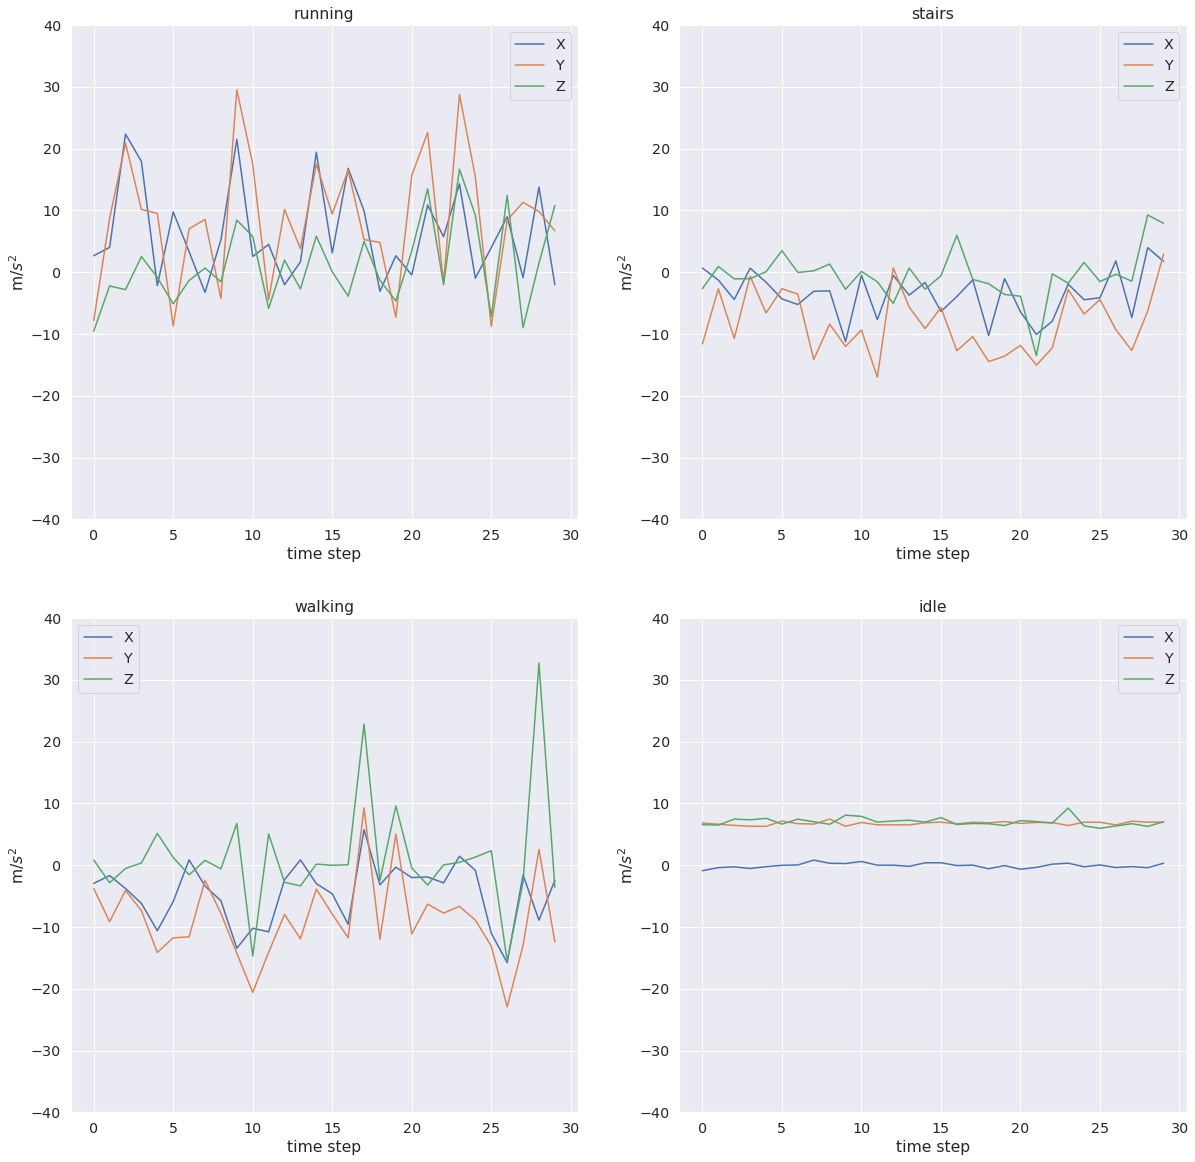

In [417]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()


steps = np.arange(30)

for ax, label in zip(axes, classes):
    sample = raw_data[raw_data['label'] == label].iloc[0]
    sns.lineplot(y=sample[x_acc_cols].astype(float), x=steps, label='X', ax=ax)
    sns.lineplot(y=sample[y_acc_cols].astype(float), x=steps, label='Y', ax=ax)
    sns.lineplot(y=sample[z_acc_cols].astype(float), x=steps, label='Z', ax=ax).set_title(label)
    ax.set_ylim(-40, 40)
    ax.set_xlabel('time step')
    ax.set_ylabel('m/$s^2$')

## Mean for each axis

We can see, that calculating mean for every axis is enough to separate all classes for each other, except for 'walking' vs 'stairs'

In [28]:
mean_x = raw_data[x_acc_cols].mean(axis=1)
mean_y = raw_data[y_acc_cols].mean(axis=1)
mean_z = raw_data[z_acc_cols].mean(axis=1)

simple_features = pd.DataFrame({
    'mean_x': mean_x,
    'mean_y': mean_y,
    'mean_z': mean_z,
    'label': raw_data['label']
})

Pairplot of mean accelerometer value during frame of length 30


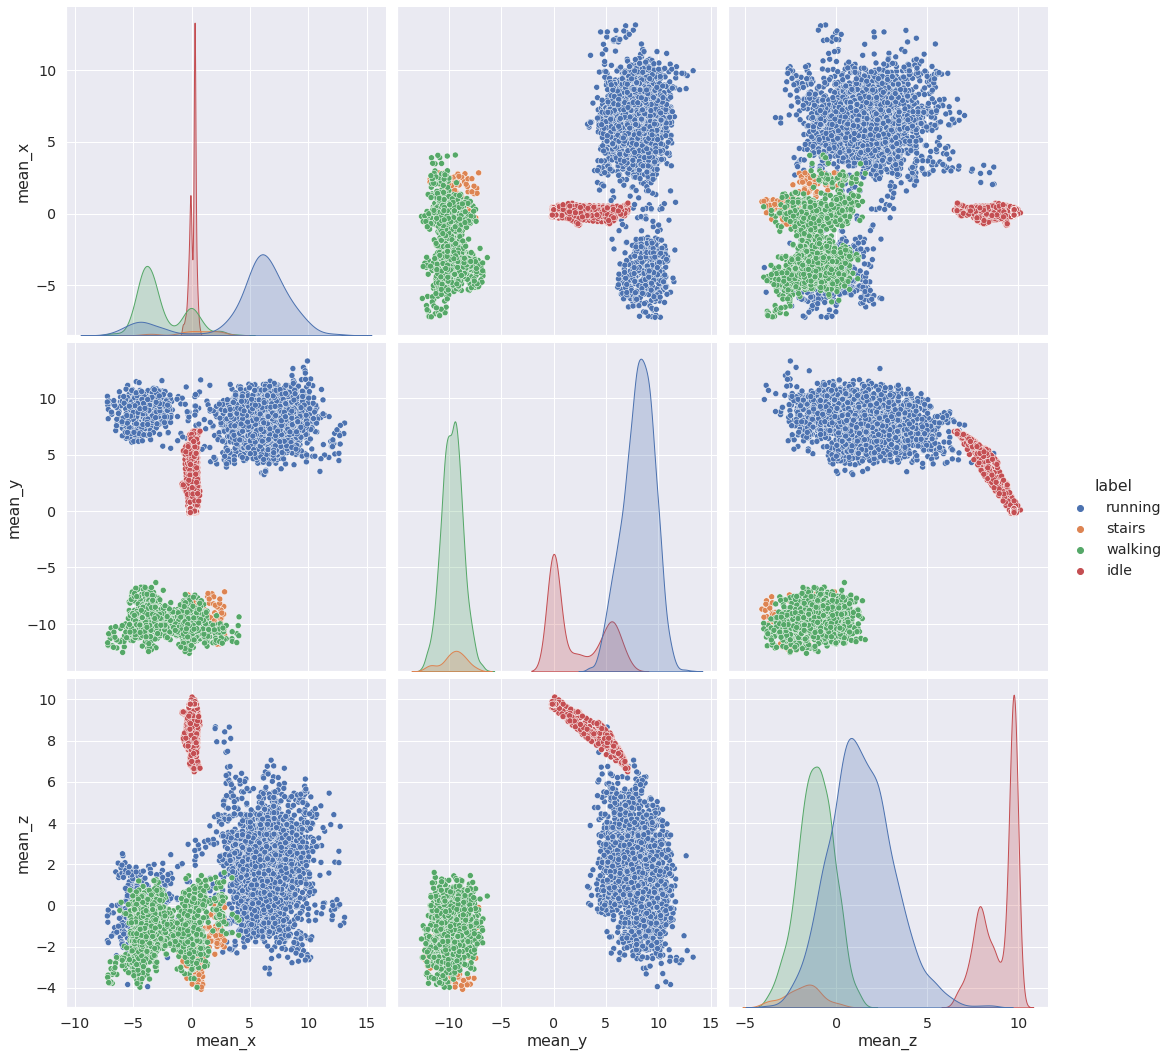

In [421]:
print('Pairplot of mean accelerometer value during frame of length 30');
sns.pairplot(data=simple_features, hue='label', height=5);


# 2. Setup validation and baselines <a class="anchor" id="section_2"></a>

## StratifiedKFold

In [6]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [8]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} "stairs", {value_counts.running} "running" samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 "stairs", 682 "running" samples
split#1, we have 33 "stairs", 682 "running" samples
split#2, we have 33 "stairs", 682 "running" samples
split#3, we have 33 "stairs", 681 "running" samples
split#4, we have 33 "stairs", 681 "running" samples


In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# target label encoder
target_le = LabelEncoder()
target_le.fit(classes)

LabelEncoder()

## Baselines

In [54]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score
from IPython.display import display, HTML

In [450]:
numerical_metrics = ['accuracy', 'f1_macro', 'f1_min']

def evaluate_performance(y_true, y_pred):
    """Calculates metrics and returns result as dict"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_min': f1_score(y_true, y_pred, average=None).min(),
        'CM': confusion_matrix(y_true, y_pred, normalize='true'),
        'CM_not_normalized': confusion_matrix(y_true, y_pred),
    }
    
    return metrics

def plot_confusion_matrix(df, title=None):
    # C_ij - i is true, predicted in j
    cm = np.stack(df['CM'].values, axis=0).mean(axis=0)
    cm_nn = np.stack(df['CM_not_normalized'].values, axis=0).mean(axis=0)
    cm_print = np.empty_like(cm_nn).astype(str)
    for i in range(4):
        for j in range(4):
            cm_print[i,j] = ("%.2f" % (cm[i,j]*100))+'%\n'+str(cm_nn[i,j])
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.3)
    labels_ordered = target_le.inverse_transform(range(4))
    sns.heatmap(cm,
                annot=cm_print,
                fmt='',
                cmap='Blues',
                cbar=False,
                xticklabels=labels_ordered,
                yticklabels=labels_ordered,
               )
    plt.xlabel('predicted')
    plt.ylabel('actual');
    plt.title(title);
    
def print_cv_metrics(cv_metrics, title=None):
    """Displays results on cross validation"""
    df = pd.DataFrame(cv_metrics)
    plot_confusion_matrix(df, title=title);
    plt.show()
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df = print_df.applymap(lambda x: round(x, 3))
    print_df.columns = ['mean', 'std']
    display(HTML(print_df.T.to_html()))    
    

[[208   0   0   0]
 [  4 678   0   0]
 [  0   0  11  22]
 [  0   0   3 367]]
[[208   0   0   0]
 [  2 680   0   0]
 [  0   0   8  25]
 [  0   0   1 369]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   1 369]]
[[208   0   0   0]
 [  3 678   0   0]
 [  0   0  10  23]
 [  0   0   9 361]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  13  20]
 [  0   0   7 363]]


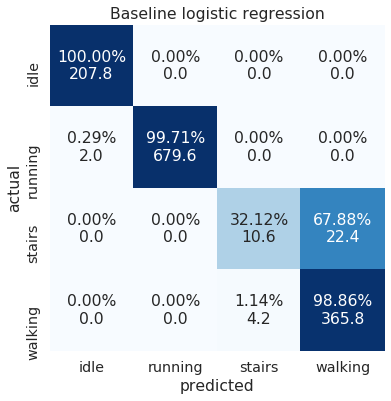

,accuracy,f1_macro,f1_min
mean,0.978,0.850,0.443
std,0.003,0.015,0.055


In [451]:
X = simple_features[['mean_x', 'mean_y', 'mean_z']]
y = simple_features['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Baseline logistic regression')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  17  16]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  17  16]
 [  0   0   2 368]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  18  15]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  18  15]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  19  14]
 [  0   0   4 366]]


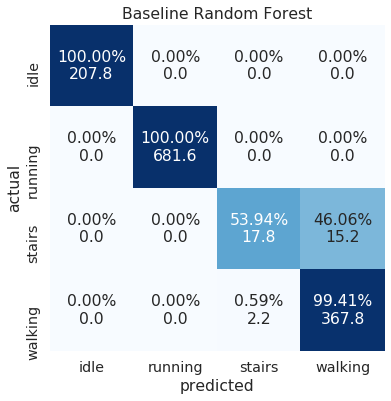

,accuracy,f1_macro,f1_min
mean,0.987,0.912,0.672
std,0.001,0.005,0.017


In [452]:
X = simple_features[['mean_x', 'mean_y', 'mean_z']]
y = simple_features['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_valid = scaler.transform(X_valid)
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Baseline Random Forest')

# 3. Feature engineering <a class="anchor" id="section_3"></a>

In [453]:
def extract_features(x_part, y_part, z_part):
    """
    Extract features from accelerometer readings.
    
    First, magnitude across 3 axes is calculed and added as 4ht timeseries 'm'
    Then, the followng features for each axis is calculated:
    - mean: simple average for each axis
    - minmax: difference between max value and min value for each axis
    - min: minumum value for each axis
    - rms: root mean square for each axis
    - corr_xy, corr_yz, corr_xz - Pearson correlation coefs. for corresponding axis.
    
    as proposed in 'A Study on Human Activity Recognition Using Accelerometer Data from Smartphones' 
    https://www.sciencedirect.com/science/article/pii/S1877050914008643

    Parameters:
            x_part, y_part, z_part: Arrays of shape n_samples x FRAME_LENGTH
            with accelerometer readings

    Returns:
            features (DataFrame): DataFrame with generated features (19 features in total)
    """
    magnitude_part = np.sqrt(x_part**2 + y_part**2 + z_part**2)
    ts_matrix = np.stack([x_part, y_part, z_part, magnitude_part], axis=1)
    ts_ax_names = ['x', 'y', 'z', 'm']
    assert len(ts_ax_names) == ts_matrix.shape[1]
    
    mean_features = pd.DataFrame(ts_matrix.mean(axis=2), columns=[f'mean_{ax}' for ax in ts_ax_names])
    
    minmax_m = ts_matrix.max(axis=2) - ts_matrix.min(axis=2)
    minmax_features = pd.DataFrame(minmax_m, columns=[f'minmax_{ax}' for ax in ts_ax_names])
    
    std_m = ts_matrix.std(axis=2)
    std_features = pd.DataFrame(std_m, columns=[f'std_{ax}' for ax in ts_ax_names])
    
    min_m = ts_matrix.min(axis=2)
    min_features = pd.DataFrame(min_m, columns=[f'min_{ax}' for ax in ts_ax_names])
    
    rms_m = np.sqrt(np.square(ts_matrix).mean(axis=2))
    rms_features = pd.DataFrame(rms_m, columns=[f'rms_{ax}' for ax in ts_ax_names])
    
    ix = np.arange(len(ts_matrix))
    iy = ix + len(ts_matrix)
    corr_xy = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 1, :])[ix,iy]
    corr_yz = np.corrcoef(ts_matrix[:, 1, :], ts_matrix[:, 2, :])[ix,iy]
    corr_xz = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 2, :])[ix,iy]
    corr_features = pd.DataFrame({'corr_xy': corr_xy, 'corr_yz': corr_yz, 'corr_xz': corr_xz})
    
    features = pd.concat([mean_features, minmax_features, min_features, rms_features, corr_features], axis=1)
    return features

In [454]:
feature_df = extract_features(
    raw_data[x_acc_cols].values,
    raw_data[y_acc_cols].values,
    raw_data[z_acc_cols].values)

In [455]:
feature_df['label'] = target_le.transform(raw_data['label'])

In [456]:
all_features = [c for c in feature_df.columns if c != 'label']
print('len(all_features): ', len(all_features))
all_features

len(all_features):  19


['mean_x',
 'mean_y',
 'mean_z',
 'mean_m',
 'minmax_x',
 'minmax_y',
 'minmax_z',
 'minmax_m',
 'min_x',
 'min_y',
 'min_z',
 'min_m',
 'rms_x',
 'rms_y',
 'rms_z',
 'rms_m',
 'corr_xy',
 'corr_yz',
 'corr_xz']

# 4. Modeling <a class="anchor" id="section_4"></a>

## 4.1 Logistic regression <a class="anchor" id="section_4_1"></a>

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  29   4]
 [  0   0   7 363]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  21  12]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   3 367]]


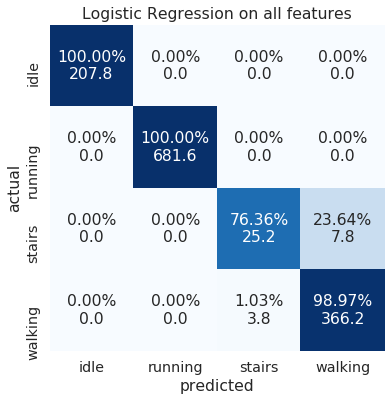

,accuracy,f1_macro,f1_min
mean,0.991,0.948,0.809
std,0.003,0.018,0.067


In [457]:
X = feature_df[all_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=1_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Logistic Regression on all features')

### Adding polynomial features

In [458]:
from sklearn.preprocessing import PolynomialFeatures

poly_transform = PolynomialFeatures(2, include_bias=False)

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   3 367]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]


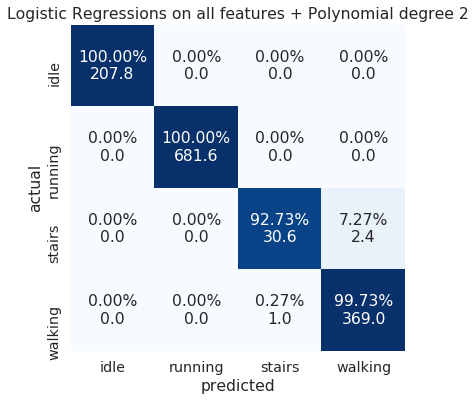

,accuracy,f1_macro,f1_min
mean,0.997,0.986,0.947
std,0.001,0.008,0.030


In [459]:
X = poly_transform.fit_transform(feature_df[all_features])
y = feature_df['label'].values
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=1_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Logistic Regressions on all features + Polynomial degree 2')

### Feature selection with L1 regularization

In [460]:
X = poly_transform.fit_transform(feature_df[all_features])
y = feature_df['label'].values

def l1_objective(C=1.0):
    cv_metrics = []

    for train_ix, valid_ix in kfold.split(X, y):
        X_train, X_valid = X[train_ix], X[valid_ix]
        y_train, y_valid = y[train_ix], y[valid_ix]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        cls = linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C)
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_valid)

        fold_metrics = evaluate_performance(y_valid, y_pred)
        cv_metrics.append(fold_metrics)
    return cv_metrics

In [461]:
from tqdm.cli import tqdm

In [163]:
Cs = np.linspace(1e-3, 1.5, num=10)
f1_values = []
f1_stds   = []

for C in tqdm(Cs):
    cv_metrics = l1_objective(C=C)
    df = pd.DataFrame(cv_metrics)
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    f1_macro = print_df.loc['f1_macro']
    f1_values.append(f1_macro['mean'])
    f1_stds.append(f1_macro['std'])


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


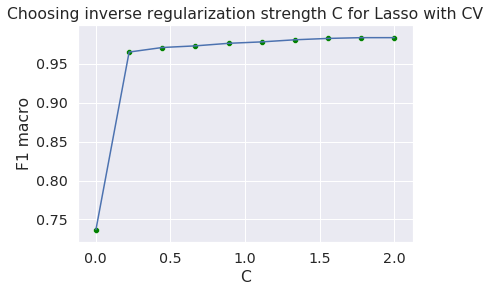

In [164]:
sns.lineplot(x=Cs, y=f1_mean_values)
sns.scatterplot(x=Cs, y=f1_mean_values, color='green')

plt.xlabel('C')
plt.ylabel('F1 macro')
plt.title('Choosing inverse regularization strength C for Lasso with CV');

In [165]:
Cs[1]

0.22311111111111112

In [166]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

lasso_cls = linear_model.LogisticRegression(penalty='l1', C=.2, solver='liblinear')
lasso_cls.fit(X_scaled, y)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [167]:
importance_coefs = np.abs(lasso_cls.coef_).max(axis=0)
feature_importance = list(zip(poly_transform.get_feature_names(all_features), importance_coefs))

important_features = [(name, coef) for name, coef in feature_importance]
importance_df = pd.DataFrame(important_features, columns = ['feature_name', 'importance']
                            ).sort_values(by='importance', ascending=False
                            ).reset_index(drop=True)

In [168]:
importance_df.head()

,feature_name,importance
0,mean_y min_x,2.095195
1,mean_z^2,1.659548
2,mean_x min_z,1.592735
3,min_x min_m,1.497705
4,rms_z,1.474479


In [171]:
importance_df[importance_df['importance'] > 1e-2].shape

(60, 2)

#### Choosing optimal number of features

In [209]:
def l2_objective_n_features(selected_features):
    X = poly_transform.fit_transform(feature_df[all_features])
    X = pd.DataFrame(X, columns = poly_transform.get_feature_names(all_features))
    X = X[selected_features]
    y = feature_df['label']

    cv_metrics = []

    for train_ix, valid_ix in kfold.split(X, y):
        X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
        y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        cls = linear_model.LogisticRegression(penalty='l2', max_iter=2_000)
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_valid)

        fold_metrics = evaluate_performance(y_valid, y_pred)
        cv_metrics.append(fold_metrics)
    return cv_metrics

In [210]:
n_features = np.arange(1, 61)

scores = {
    'selected_features': [],
    'f1_macro': [],
    'f1_macro_std': [],
    'f1_min': [],
    'f1_min_std': [],
}

for n in tqdm(n_features):
    selected_features = importance_df['feature_name'].head(n).values
    cv_metrics = l2_objective_n_features(selected_features)
    df = pd.DataFrame(cv_metrics)
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    f1_macro = print_df.loc['f1_macro']
    scores['selected_features'].append(selected_features)
    scores['f1_macro'].append(print_df.loc['f1_macro']['mean'])    
    scores['f1_macro_std'].append(print_df.loc['f1_macro']['std'])
    
    scores['f1_min'].append(print_df.loc['f1_min']['mean'])    
    scores['f1_min_std'].append(print_df.loc['f1_min']['std'])    



100%|██████████| 60/60 [01:06<00:00,  1.11s/it]


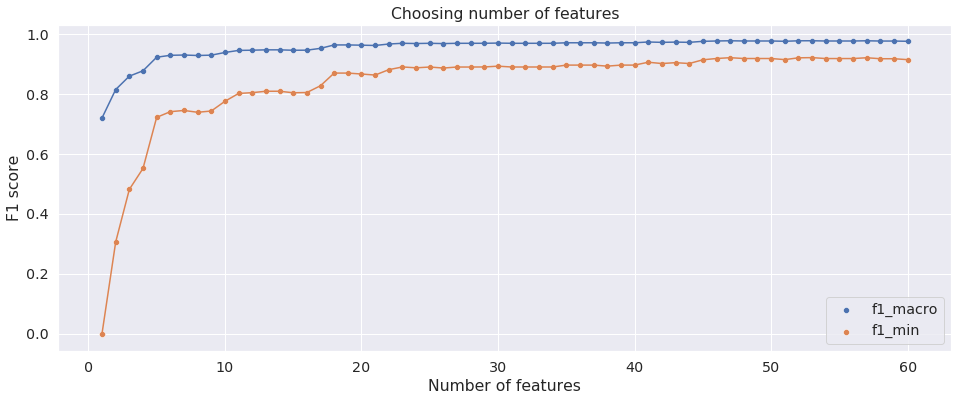

In [212]:
plt.figure(figsize=(16,6))
sns.lineplot(x=n_features, y=scores['f1_macro'])
sns.scatterplot(x=n_features, y=scores['f1_macro'], label='f1_macro')

sns.lineplot(x=n_features, y=scores['f1_min'])
sns.scatterplot(x=n_features, y=scores['f1_min'], label='f1_min')

plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.title('Choosing number of features');

In [215]:
top_23_features = importance_df['feature_name'].head(23).values
top_23_features

array(['mean_y min_x', 'mean_z^2', 'mean_x min_z', 'min_x min_m', 'rms_z',
       'mean_z min_m', 'mean_y mean_z', 'mean_x mean_y', 'mean_z',
       'mean_y min_y', 'mean_y minmax_y', 'min_z rms_x', 'mean_x corr_xz',
       'mean_y minmax_m', 'mean_z rms_y', 'mean_z min_z', 'minmax_y^2',
       'mean_y corr_xy', 'minmax_m', 'mean_y rms_z', 'mean_x min_y',
       'corr_yz^2', 'min_z^2'], dtype=object)

### Final model

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  26   7]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   6 364]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  30   3]
 [  0   0   4 366]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  27   6]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   1 369]]


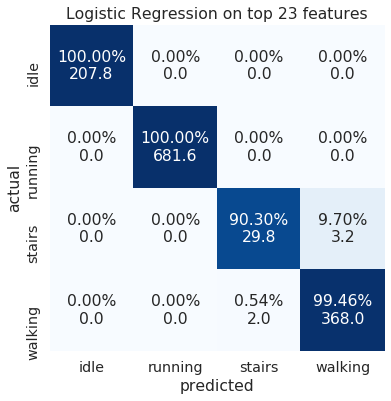

,accuracy,f1_macro,f1_min
mean,0.996,0.978,0.919
std,0.002,0.011,0.040


In [462]:
X = poly_transform.fit_transform(feature_df[all_features])
X = pd.DataFrame(X, columns = poly_transform.get_feature_names(all_features))
X = X[top_23_features]
y = feature_df['label']

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=1_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Logistic Regression on top 23 features')

## 4.2 RandomForest <a class="anchor" id="section_4_2"></a>

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]


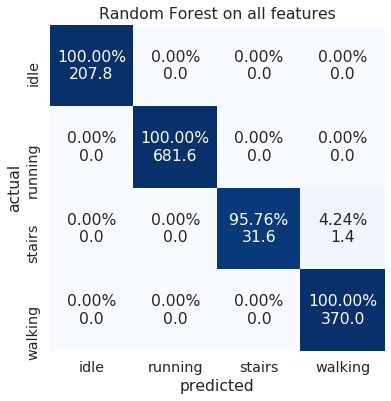

,accuracy,f1_macro,f1_min
mean,0.999,0.994,0.978
std,0.001,0.006,0.021


In [463]:
X = feature_df[all_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Random Forest on all features')

In [426]:
X = feature_df[all_features]
y = feature_df['label']

cls = RandomForestClassifier()
cls.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [427]:
cls.feature_importances_

array([0.04523284, 0.17702365, 0.04634602, 0.05077193, 0.1015155 ,
       0.07233117, 0.01374318, 0.0372923 , 0.0125479 , 0.05688412,
       0.05746173, 0.00470738, 0.18816406, 0.04786677, 0.00483306,
       0.07322783, 0.00370949, 0.00287694, 0.00346414])

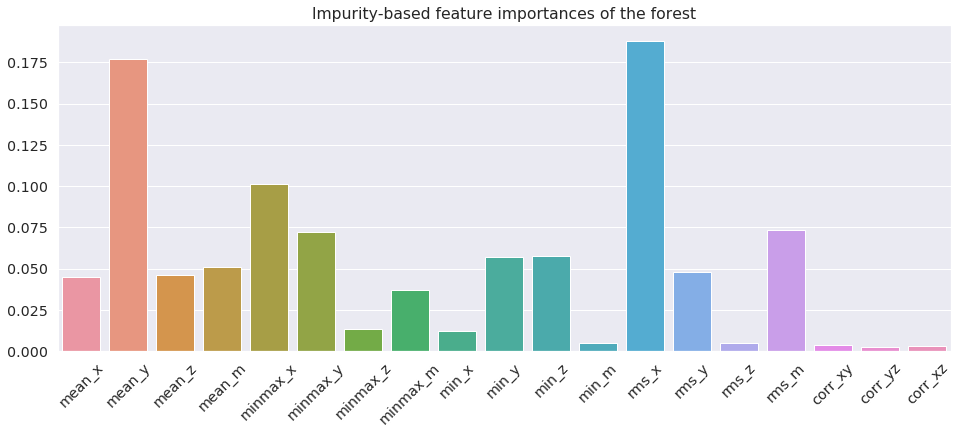

In [428]:
plt.figure(figsize=(16, 6));
plt.title('Impurity-based feature importances of the forest')
plot = sns.barplot(x=all_features, y=cls.feature_importances_)
for item in plot.get_xticklabels():
    item.set_rotation(45)

In [429]:
importance_df = pd.DataFrame(zip(all_features, cls.feature_importances_), columns = ['feature_name', 'importance']
                            ).sort_values(by='importance', ascending=False
                            ).reset_index(drop=True)
importance_df.head()

,feature_name,importance
0,rms_x,0.188164
1,mean_y,0.177024
2,minmax_x,0.101515
3,rms_m,0.073228
4,minmax_y,0.072331


In [431]:
top_10_features = importance_df['feature_name'].head(10).values
top_10_features

array(['rms_x', 'mean_y', 'minmax_x', 'rms_m', 'minmax_y', 'min_z',
       'min_y', 'mean_m', 'rms_y', 'mean_z'], dtype=object)

In [432]:
def RF_objective_n_features(selected_features):
    X = feature_df[selected_features]
    y = feature_df['label']

    cv_metrics = []

    for train_ix, valid_ix in kfold.split(X, y):
        X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
        y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]

        cls = RandomForestClassifier()
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_valid)

        fold_metrics = evaluate_performance(y_valid, y_pred)
        cv_metrics.append(fold_metrics)
    return cv_metrics

In [433]:
n_features = np.arange(1, len(all_features)+1)

scores = {
    'selected_features': [],
    'f1_macro': [],
    'f1_macro_std': [],
    'f1_min': [],
    'f1_min_std': [],
}

for n in tqdm(n_features):
    selected_features = importance_df['feature_name'].head(n).values
    cv_metrics = RF_objective_n_features(selected_features)
    df = pd.DataFrame(cv_metrics)
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    f1_macro = print_df.loc['f1_macro']
    scores['selected_features'].append(selected_features)
    scores['f1_macro'].append(print_df.loc['f1_macro']['mean'])    
    scores['f1_macro_std'].append(print_df.loc['f1_macro']['std'])
    
    scores['f1_min'].append(print_df.loc['f1_min']['mean'])    
    scores['f1_min_std'].append(print_df.loc['f1_min']['std'])    



100%|██████████| 19/19 [00:37<00:00,  1.99s/it]


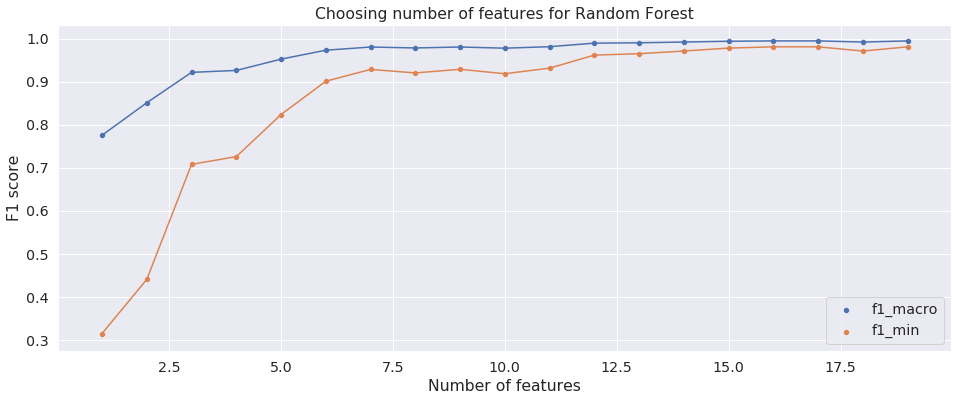

In [435]:
plt.figure(figsize=(16,6))
sns.lineplot(x=n_features, y=scores['f1_macro'])
sns.scatterplot(x=n_features, y=scores['f1_macro'], label='f1_macro')

sns.lineplot(x=n_features, y=scores['f1_min'])
sns.scatterplot(x=n_features, y=scores['f1_min'], label='f1_min')

plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.title('Choosing number of features for Random Forest');

In [261]:
top_7_features = importance_df['feature_name'].head(7).values
top_7_features

array(['mean_y', 'rms_x', 'minmax_y', 'rms_m', 'min_y', 'min_z', 'mean_x'],
      dtype=object)

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]


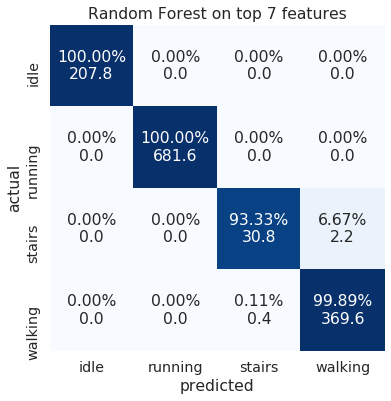

,accuracy,f1_macro,f1_min
mean,0.997988,0.988828,0.958811
std,0.00169582,0.00961409,0.0355137


In [440]:
X = feature_df[top_7_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Random Forest on top 7 features')

### out-of-bag errors

Each tree in Random forest is trained on subsample of the original data. We expect that for each training sample there are trees in our forest that had not seen this sample during training. Thus, we can make a good estimate of **generalization ability** of our forest even without holdout set or crossvalidation.

In [279]:
X = feature_df[top_7_features]
y = feature_df['label']

cls = RandomForestClassifier(n_estimators=100, oob_score=True)
cls.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [280]:
oob_preds = cls.oob_decision_function_.argmax(axis=1)
confusion_matrix(y, oob_preds)

array([[1039,    0,    0,    0],
       [   0, 3408,    0,    0],
       [   0,    0,  156,    9],
       [   0,    0,    2, 1848]])

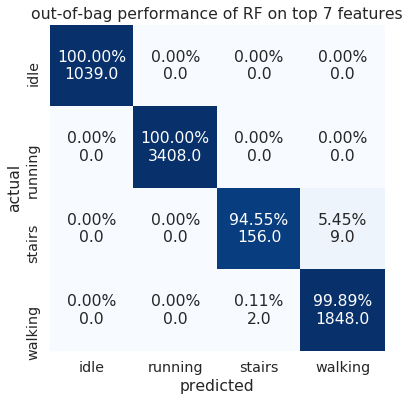

,accuracy,f1_macro,f1_min
mean,0.998298,0.990744,0.965944
std,NaN,NaN,NaN


In [283]:
print_cv_metrics([evaluate_performance(y, oob_preds)], 'out-of-bag performance of RF on top 7 features')

### Tuning Random Forest on 5 features

In [323]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [347]:
space = {
    "n_estimators": scope.int(hp.quniform("n_estimators", 20, 1000, 1)),
    "max_depth": hp.choice('max_depth', [None, scope.int(hp.quniform("max_depth_int", 1, 20,1))] ),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

MAX_EVALS = 100

In [348]:
top_5_features = importance_df['feature_name'].head(5).values
top_5_features

array(['mean_y', 'rms_x', 'minmax_y', 'rms_m', 'min_y'], dtype=object)

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  24   9]
 [  0   0   1 369]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  25   8]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  28   5]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  27   6]
 [  0   0   0 370]]


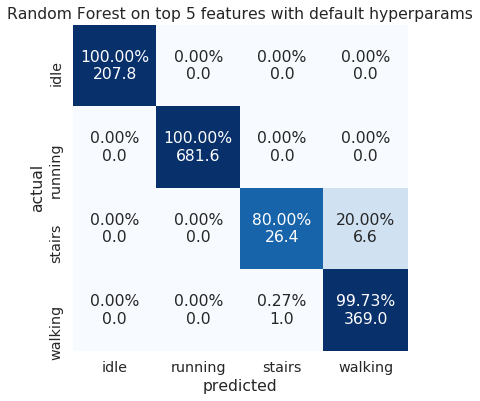

,accuracy,f1_macro,f1_min
mean,0.99412,0.965811,0.873432
std,0.00140485,0.00908704,0.0339446


In [443]:
X = feature_df[top_5_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier(
        random_state=1
    )
    
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Random Forest on top 5 features with default hyperparams')

In [355]:
X = feature_df[top_5_features]
y = feature_df['label']

def RF_objective_hyperparams(params):
#     print(params)
    cv_metrics = []

    for train_ix, valid_ix in kfold.split(X, y):
        X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
        y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]

        cls = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            criterion=params['criterion'],
            random_state=1
        )
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_valid)

        fold_metrics = evaluate_performance(y_valid, y_pred)
        cv_metrics.append(fold_metrics)
        
    loss = 1 - pd.DataFrame(cv_metrics)['f1_min'].mean()
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [356]:
%%time
RF_objective_hyperparams({'n_estimators': 100, 'criterion': 'gini', 'max_depth': None})

CPU times: user 1.54 s, sys: 92 µs, total: 1.54 s
Wall time: 1.54 s


{'loss': 0.1265682941288604,
 'params': {'n_estimators': 100, 'criterion': 'gini', 'max_depth': None},
 'status': 'ok'}

In [357]:
bayes_trials = Trials()

# Optimize
best = fmin(fn = RF_objective_hyperparams, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 100/100 [12:22<00:00,  7.42s/trial, best loss: 0.11941416388579906]


In [360]:
best_params = space_eval(space, best)
# best_params = {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 274}
best_params

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 274}

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  25   8]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  26   7]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  27   6]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  27   6]
 [  0   0   0 370]]


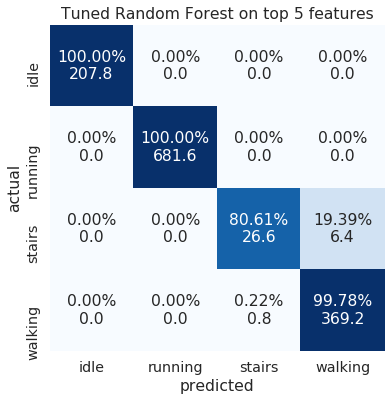

,accuracy,f1_macro,f1_min
mean,0.994429,0.967733,0.880586
std,0.00084798,0.00523087,0.0194846


In [441]:
X = feature_df[top_5_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        criterion=best_params['criterion'],
        random_state=1
    )
    
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics, 'Tuned Random Forest on top 5 features')